# Static Visualization Project

@ Jonas Zhonghan Xie

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from tqdm import tqdm
from thefuzz import fuzz, process

alt.data_transformers.disable_max_rows()


symbol_list = ["†", "–", "‡"]

nyc_counties = [
    "Bronx County",
    "Kings County",
    "New York County",
    "Queens County",
    "Richmond County",
    "BRONX",
    "KINGS",
    "NEW YORK",
    "QUEENS",
    "RICHMOND",
]

In [3]:
def clean_type(x):
    if type(x) == str:
        x = x.replace(">", "").replace("<", "").replace(" ", "").replace("%", "")
    if x in symbol_list:
        return np.nan
    elif x == "2-No":
        return "0"
    elif x == "1-Yes":
        return "1"
    else:
        return x


def find_nearest(lat1, lon1, df2):
    """Find the nearest point in df2 to the point (lat1, lon1)"""
    distances = np.sqrt((df2["Latitude"] - lat1) ** 2 + (df2["Longitude"] - lon1) ** 2)
    nearest_index = distances.idxmin()
    return df2.loc[nearest_index]


def find_best_match(school_name, choices):
    """Find the best match for school_name in choices using fuzzy matching"""
    best_match, score, _ = process.extractOne(
        school_name, choices, scorer=fuzz.token_sort_ratio
    )
    return best_match, score

In [4]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Display:ital,wght@0,100..900;1,100..900&family=Sofia+Sans:wght@1..1000&display=swap');
</style>

In [79]:
# TO DO: Modify this code to fit the above style guide
@alt.theme.register("my_theme", enable=True)  # Comment this line out for Altair 5.2


# the theme is defined as a function
def my_theme_solution():
    # you can set variables here and reuse later in the function
    font = "Noto Sans Display"

    backgroundColor = "#EBF2f6"

    font_color = "#000000"

    font_size = {"XL": 18, "L": 16, "M": 14, "S": 12, "XS": 10}

    diverging_palette = [
        "#006ea0",
        "#4d9abd",
        "#99c5d9",
        "#ffffff",
        "#e3c2b3",
        "#c68466",
        "#a03200",
    ]

    return {
        "config": {
            "title": {
                "anchor": "start",
                "font": font,
                "fontWeight": 700,
                "fontSize": font_size["XL"],
                "subtitleFontSize": font_size["L"],
                "subtitleFont": font,
                "offset": 20,
            },
            "axisX": {
                "titleFontSize": font_size["M"],
                "labelFontSize": font_size["S"],
                "grid": False,
                "labelFont": font,
            },
            "axisY": {
                "domain": False,
                "titleFontSize": font_size["M"],
                "titleAngle": 0,
                "titleBaseline": "bottom",
                "titleAnchor": "start",
                "labelFontSize": font_size["S"],
                "grid": True,
                "gridColor": "#aab0c0",
                "gridWidth": 1,
                "labelFont": font,
            },
            "axis": {
                "labelFont": font,
                "titleFont": font,
                "titleFontSize": font_size["M"],
                "labelFontSize": font_size["S"],
            },
            "background": backgroundColor,
            "view": {
                "fill": backgroundColor,
                "stroke": None,
                "padding": {"left": 5, "top": 10, "right": 5, "bottom": 10},
            },
            "range": {
                "category": [
                    "#006EA0",
                    "#32C0D2",
                    "#E0B265",
                    "#00969F",
                    "#973C4C",
                    "#AC8B96",
                ],
                "ramp": ["#fef0d9", "#fdcc8a", "#fc8d59", "#e34a33", "#b30000"],
                "diverging": diverging_palette,
            },
            "area": {},
            "line": {},
            "point": {},
            "text": {
                "fontSize": font_size["S"],
            },
            "bar": {"binSpacing": 1, "size": 25},
            "facet": {
                "titleFontSize": font_size["M"],
            },
            "notes": {"fontSize": font_size["XS"]},
            "sources": {"fontSize": font_size["XS"]},
        },
        "padding": {"left": 20, "top": 20, "right": 5, "bottom": 10},
    }

## Data Preparation

In [6]:
# Prepare BEDS-DBN Crosswalk
df_lcgms = pd.read_csv("./data/lcgms_geocoded.csv", header=0, encoding="ISO-8859-1")
df_lcgms = df_lcgms[["Location Name", "ATS System Code", "Latitude", "Longitude"]]
df_lcgms.dropna(subset=["Latitude", "Longitude"], inplace=True)
df_lcgms.rename(
    columns={"Location Name": "School Name", "ATS System Code": "DBN"}, inplace=True
)
df_lcgms["School Name"] = df_lcgms["School Name"].str.upper()
df_lcgms["Latitude"] = df_lcgms["Latitude"].astype(float)
df_lcgms["Longitude"] = df_lcgms["Longitude"].astype(float)
df_lcgms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1837 entries, 3 to 1842
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   School Name  1837 non-null   object 
 1   DBN          1837 non-null   object 
 2   Latitude     1837 non-null   float64
 3   Longitude    1837 non-null   float64
dtypes: float64(2), object(2)
memory usage: 71.8+ KB


In [7]:
df_lcgms_names = df_lcgms["School Name"].unique().tolist()

In [8]:
df_public = pd.read_csv("data/NCES_public_clean.csv", header=0)
df_public.drop(columns=["School Name [Public School] 2015-16"], inplace=True)
df_public.columns = df_public.columns.str.replace(" [Public School] 2015-16", "")
df_public.columns

Index(['Unnamed: 0', 'School Name',
       'State Name [Public School] Latest available year', 'State Name',
       'State Abbr [Public School] Latest available year',
       'School ID - NCES Assigned [Public School] Latest available year',
       'Agency Name',
       'Agency ID - NCES Assigned [Public School] Latest available year',
       'County Name', 'County Number', 'Web Site URL',
       'Years School Reported Data [Public School] Latest available year',
       'Location City', 'Location State Abbr', 'Location ZIP', 'School Type',
       'Agency Type [District] 2015-16', 'Charter School', 'Magnet School',
       'Shared Time School', 'Urban-centric Locale', 'School-wide Title I',
       'Title I Eligible School', 'Title I School Status', 'Latitude',
       'Longitude', 'Congressional Code', 'National School Lunch Program',
       'Total Students All Grades (Excludes AE)',
       'Total Students All Grades (Includes AE)', 'Free Lunch Eligible',
       'Reduced-price Lunch Eligi

In [9]:
df_public_location = df_public[df_public["County Name"].isin(nyc_counties)][
    ["School Name", "Latitude", "Longitude"]
]

df_public_location.dropna(subset=["Latitude", "Longitude"], inplace=True)
df_public_location["Latitude"] = df_public_location["Latitude"].apply(clean_type)
df_public_location["Longitude"] = df_public_location["Longitude"].apply(clean_type)

df_public_location["Latitude"] = df_public_location["Latitude"].astype(float)
df_public_location["Longitude"] = df_public_location["Longitude"].astype(float)

df_public_names = df_public_location["School Name"].unique()

In [10]:
df_public_location["Best Match"], df_public_location["Score"] = zip(
    *df_public_location["School Name"].apply(
        lambda x: find_best_match(x, df_lcgms["School Name"])
    )
)
df_public_location = df_public_location[df_public_location["Score"] >= 90]

In [11]:
df_public_location = df_public_location.merge(
    df_lcgms[["School Name", "DBN"]],
    left_on="Best Match",
    right_on="School Name",
    how="left",
)

In [12]:
df_public_crosswalk = df_public_location[
    ["DBN", "School Name_x", "Latitude", "Longitude"]
].drop_duplicates()
df_public_crosswalk.rename(columns={"School Name_x": "School Name"}, inplace=True)

In [13]:
df_public = df_public[
    [
        "School Name",
        "State Name",
        "County Name",
        "Location City",
        "Location ZIP",
        "School Type",
        "Charter School",
        "Magnet School",
        "Urban-centric Locale",
        "Title I Eligible School",
        "Total Students All Grades (Excludes AE)",
        "Free and Reduced Lunch Students",
        "American Indian/Alaska Native Students",
        "Asian or Asian/Pacific Islander Students",
        "Hispanic Students",
        "Black or African American Students",
        "White Students",
        "Nat. Hawaiian or Other Pacific Isl. Students",
        "Two or More Races Students",
        "Pupil/Teacher Ratio",
    ]
]

df_public.rename(
    columns={
        "Location City": "City",
        "Location ZIP": "ZIP",
        "Total Students All Grades (Excludes AE)": "Total Students",
        "Title I Eligible School": "Title I Eligible",
        "Free and Reduced Lunch Students": "FRL",
        "American Indian/Alaska Native Students": "American Indian/Alaska Native",
        "Asian or Asian/Pacific Islander Students": "Asian",
        "Hispanic Students": "Hispanic",
        "Black or African American Students": "Black",
        "White Students": "White",
        "Nat. Hawaiian or Other Pacific Isl. Students": "Other",
        "Two or More Races Students": "Multi-Race",
    },
    inplace=True,
)

In [14]:
for column in df_public.columns:
    if column not in ["School Name", "State Name", "County Name", "City", "ZIP"]:
        df_public[column] = df_public[column].apply(clean_type)

for column in [
    "Charter School",
    "Magnet School",
    "Title I Eligible",
    "Total Students",
    "FRL",
    "American Indian/Alaska Native",
    "Asian",
    "Hispanic",
    "Black",
    "White",
    "Other",
    "Multi-Race",
]:
    df_public[column].fillna(0, inplace=True)
    df_public[column] = df_public[column].astype(int)

df_public["Pupil/Teacher Ratio"] = df_public["Pupil/Teacher Ratio"].apply(clean_type)
df_public["Pupil/Teacher Ratio"].fillna(0, inplace=True)
df_public["Pupil/Teacher Ratio"] = df_public["Pupil/Teacher Ratio"].astype(float)

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/4237478408.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_public[column].fillna(0, inplace=True)
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/4237478408.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [15]:
# Create percentages for FRL students and students of each race

percent_columns = [
    "FRL",
    "American Indian/Alaska Native",
    "Asian",
    "Hispanic",
    "Black",
    "White",
    "Other",
    "Multi-Race",
]

for column in percent_columns:
    new_column = "Percentage of " + column
    df_public[new_column] = df_public[column] / df_public["Total Students"] * 100

In [16]:
df_private = pd.read_csv("data/NCES_private_clean.csv", header=0)
df_private.drop(columns=["Private School Name [Private School] 2015-16"], inplace=True)
df_private.columns = df_private.columns.str.replace(" [Private School] 2015-16", "")
df_private.columns

Index(['Unnamed: 0', 'Private School Name',
       'State Name [Private School] Latest available year', 'State Name',
       'ANSI/FIPS State Code [Private School] Latest available year',
       'School ID - NCES Assigned [Private School] Latest available year',
       'County Name', 'Days per School Year',
       'Length of School Day in Total Hours (Including reported minutes)',
       'Library or Library Media Center', 'City',
       'State Abbr [Private School] Latest available year', 'ZIP',
       'Urban-centric Locale', 'Lowest Grade Taught', 'Highest Grade Taught',
       'School Type', 'School Level',
       'School's Religious Affiliation or Orientation',
       'Religious Orientation', 'School Community Type', 'Coeducational',
       'Total Students (Ungraded & PK-12)', 'Total Students (Ungraded & K-12)',
       'Grades 1-8 Students', 'Grades 9-12 Students',
       'Prekindergarten Students', 'Kindergarten Students',
       'American Indian/Alaska Native Students',
       'Pe

In [17]:
df_private = df_private[
    [
        "Private School Name",
        "State Name",
        "County Name",
        "City",
        "ZIP",
        "Urban-centric Locale",
        "Total Students (Ungraded & PK-12)",
        "Percentage of American Indian/Alaska Native Students",
        "Percentage of Asian or Asian/Pacific Islander Students",
        "Percentage of Hispanic Students",
        "Percentage of Black Students",
        "Percentage of White Students",
        "Percentage of Nat. Hawaiian or Other Pacific Isl. Students",
        "Percentage of Two or More Races Students",
        "Pupil/Teacher Ratio",
    ]
]

df_private.rename(
    columns={
        "Private School Name": "School Name",
        "Total Students (Ungraded & PK-12)": "Total Students",
        "Percentage of American Indian/Alaska Native Students": "Percentage of American Indian/Alaska Native",
        "Percentage of Asian or Asian/Pacific Islander Students": "Percentage of Asian",
        "Percentage of Hispanic Students": "Percentage of Hispanic",
        "Percentage of Black Students": "Percentage of Black",
        "Percentage of White Students": "Percentage of White",
        "Percentage of Nat. Hawaiian or Other Pacific Isl. Students": "Percentage of Other",
        "Percentage of Two or More Races Students": "Percentage of Multi-Race",
    },
    inplace=True,
)


for column in df_private.columns:
    if column not in ["School Name", "State Name", "County Name", "City", "ZIP"]:
        df_private[column] = df_private[column].apply(clean_type)

for column in [
    "Total Students",
    "Percentage of American Indian/Alaska Native",
    "Percentage of Asian",
    "Percentage of Hispanic",
    "Percentage of Black",
    "Percentage of White",
    "Percentage of Other",
    "Percentage of Multi-Race",
]:
    df_private[column].fillna(0, inplace=True)
    if column == "Total Students":
        df_private[column] = df_private[column].astype(int)
    else:
        df_private[column] = df_private[column].astype(float)

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/1125110576.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_private[column].fillna(0, inplace=True)
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/1125110576.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [18]:
# Append to datasets
df_private["School Type"] = "Private"
df_private["Charter School"] = 0
df_private["Magnet School"] = 0
df_private["Title I Eligible"] = 0
df_private["FRL"] = 0

# append dataframes
df_schools = pd.concat([df_public, df_private], ignore_index=True)
df_schools = df_schools[df_schools["Total Students"] > 0]

In [19]:
# Five Counties in NYC: Bronx, Kings, New York, Queens, Richmond

nyc_counties = [
    "Bronx County",
    "Kings County",
    "New York County",
    "Queens County",
    "Richmond County",
    "BRONX",
    "KINGS",
    "NEW YORK",
    "QUEENS",
    "RICHMOND",
]

df_schools_ny = df_schools[
    (df_schools["State Name"] == "NEW YORK")
    & (df_schools["County Name"].isin(nyc_counties))
]

In [20]:
df_schools_ny["School Type"].value_counts()

School Type
1-Regularschool              1738
Private                       593
2-Specialeducationschool       58
4-Alternative/otherschool      20
3-Vocationalschool             19
Name: count, dtype: int64

In [21]:
df_schools_ny.loc[df_schools_ny["School Type"] != "Private", "School Type"] = "Public"

In [22]:
# 1856 Public School in NYC
df_schools_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2428 entries, 32 to 122463
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   School Name                                  2428 non-null   object 
 1   State Name                                   2428 non-null   object 
 2   County Name                                  2428 non-null   object 
 3   City                                         2428 non-null   object 
 4   ZIP                                          2428 non-null   object 
 5   School Type                                  2428 non-null   object 
 6   Charter School                               2428 non-null   int64  
 7   Magnet School                                2428 non-null   int64  
 8   Urban-centric Locale                         2428 non-null   object 
 9   Title I Eligible                             2428 non-null   int64  
 10  To

In [23]:
df_public_ny = df_schools_ny[df_schools_ny["School Type"] == "Public"]

In [24]:
df_public_ny = pd.merge(df_public_ny, df_public_crosswalk, on="School Name", how="left")

In [25]:
df_scoring = pd.read_excel(
    "./data/202324-ems-sqr-results.xlsx", sheet_name="Summary", header=0
)
df_scoring = df_scoring[["DBN", "School Name", "Impact Score", "Performance Score"]]

In [26]:
df_scoring.dropna(subset=["Impact Score", "Performance Score"], inplace=True)

In [27]:
df_public_ny = df_public_ny.merge(df_scoring, on="DBN", how="left")

In [28]:
df_schools_ny.to_csv("./data/cleaned_schools_ny.csv", index=False)
df_public_ny.to_csv("./data/cleaned_public_schools_ny.csv", index=False)

---

In [29]:
df_ela = pd.read_excel(
    "./data/ny-ela-results-2013-2019-public-master.xlsx", sheet_name="All", header=0
)

df_math = pd.read_excel(
    "./data/ny-math-results-2013-2019-public-master.xlsx", sheet_name="All", header=0
)

In [30]:
df_ela = df_ela[["DBN", "School Name", "Grade", "Year", "% Level 3+4"]]
df_ela = df_ela[df_ela["Grade"] == "All Grades"]
df_ela["% Level 3+4"] = df_ela["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)
df_ela["ELA Proficient"] = df_ela["% Level 3+4"]

# transform the data into wide format, save the school name
df_ela_wide = df_ela.pivot_table(
    index=["School Name", "DBN"], columns="Year", values="ELA Proficient"
).reset_index()

df_ela_wide.columns = df_ela_wide.columns[0:2].to_list() + [
    str(i) + " ELA Proficient" for i in df_ela_wide.columns[2:]
]

In [31]:
df_math = df_math[["DBN", "School Name", "Grade", "Year", "% Level 3+4"]]
df_math = df_math[df_math["Grade"] == "All Grades"]
df_math["% Level 3+4"] = df_math["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)
df_math["Math Proficient"] = df_math["% Level 3+4"]

# transform the data into wide format, save the school name
df_math_wide = df_math.pivot_table(
    index=["School Name", "DBN"], columns="Year", values="Math Proficient"
).reset_index()

df_math_wide.columns = df_math_wide.columns[0:2].to_list() + [
    str(i) + " Math Proficient" for i in df_math_wide.columns[2:]
]

In [32]:
df_all_test_long = pd.merge(
    df_ela[["DBN", "School Name", "Year", "ELA Proficient"]],
    df_math[["DBN", "School Name", "Year", "Math Proficient"]],
    on=["DBN", "School Name", "Year"],
    how="inner",
)

In [33]:
df_public_ny_test = pd.merge(df_public_ny, df_all_test_long, on=["DBN"], how="left")

In [34]:
# Tabulate the na rate in ELA proficient and Math proficient by year -> 16.8%
na_rate = (
    df_public_ny_test[df_public_ny_test["Year"].isnull()].size
    / df_public_ny_test["School Name_x"].unique().size
)
na_rate

18.8440065681445

In [35]:
df_public_final = df_public_ny_test[df_public_ny_test["Year"].notnull()]

In [36]:
df_public_final.loc[
    df_public_final["Percentage of White"] <= 20, "Segregated School"
] = 1
df_public_final.loc[
    df_public_final["Percentage of White"] > 20, "Segregated School"
] = 0

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/670116550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_public_final.loc[


In [37]:
segregate_stats = df_public_final.groupby(["Segregated School"]).agg(
    {
        "School Name_x": "count",
        "Title I Eligible": "mean",
        "Percentage of FRL": "mean",
        "ELA Proficient": "mean",
        "Math Proficient": "mean",
        "Impact Score": "mean",
        "Performance Score": "mean",
    }
)

segregate_stats

,School Name_x,Title I Eligible,Percentage of FRL,ELA Proficient,Math Proficient,Impact Score,Performance Score
Segregated School,,,,,,,
0.0,1848,0.334416,45.172073,58.516308,60.420854,0.550607,0.674751
1.0,5325,0.953427,81.099489,28.895785,28.539912,0.472403,0.438027


In [38]:
title1_stats = df_public_final.groupby("Title I Eligible").agg(
    {
        "Percentage of White": ["mean"],
        "ELA Proficient": ["mean"],
        "Math Proficient": ["mean"],
        "Pupil/Teacher Ratio": ["mean"],
        "Impact Score": "mean",
        "Performance Score": "mean",
    }
)

title1_stats

,Percentage of White,ELA Proficient,Math Proficient,Pupil/Teacher Ratio,Impact Score,Performance Score
,mean,mean,mean,mean,mean,mean
Title I Eligible,,,,,,
0,44.452833,62.772664,64.049403,15.413728,0.560485,0.704228
1,7.137904,29.716321,29.670128,13.868492,0.474931,0.445791


---

### Preparing Test Scores Wide and Long-format datasets

In [39]:
df_ela_race = pd.read_excel(
    "./data/ny-ela-results-2013-2019-public-master.xlsx",
    sheet_name="Ethnicity",
    header=0,
)

df_math_race = pd.read_excel(
    "./data/ny-math-results-2013-2019-public-master.xlsx",
    sheet_name="Ethnicity",
    header=0,
)

In [40]:
df_ela_race_cleaned = df_ela_race[
    [
        "DBN",
        "School Name",
        "Grade",
        "Category",
        "Year",
        "Mean Scale Score",
        "% Level 3+4",
    ]
]
df_ela_race_cleaned = df_ela_race_cleaned[
    (df_ela_race_cleaned["Grade"] == "All Grades")
    & (df_ela_race_cleaned["Year"] == 2019)
]
df_ela_race_cleaned["% Level 3+4"] = df_ela_race_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_cleaned["Mean Scale Score"] = df_ela_race_cleaned["Mean Scale Score"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_cleaned["ELA Proficient"] = df_ela_race_cleaned["% Level 3+4"]
df_ela_race_cleaned.rename(
    columns={"Mean Scale Score": "ELA Mean Scale Score"}, inplace=True
)

df_ela_race_wide = df_ela_race_cleaned.pivot_table(
    index=["School Name", "DBN"], columns="Category", values=["ELA Proficient"]
).reset_index()


df_ela_race_wide.columns = [
    i[1] if i[1] != "" else i[0] for i in df_ela_race_wide.columns.to_list()
]
df_ela_race_wide.columns = df_ela_race.columns[0:2].to_list() + [
    i + " ELA Proficient" for i in df_ela_race_wide.columns[2:]
]

In [41]:
df_ela_race_long_cleaned = df_ela_race[
    [
        "DBN",
        "School Name",
        "Grade",
        "Category",
        "Year",
        "Mean Scale Score",
        "% Level 3+4",
    ]
]
df_ela_race_long_cleaned = df_ela_race_long_cleaned[
    df_ela_race_long_cleaned["Grade"] == "All Grades"
]
df_ela_race_long_cleaned["% Level 3+4"] = df_ela_race_long_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_long_cleaned["Mean Scale Score"] = df_ela_race_long_cleaned[
    "Mean Scale Score"
].apply(lambda x: float(x) if x != "s" else np.nan)

df_ela_race_long_cleaned["ELA Proficient"] = df_ela_race_long_cleaned["% Level 3+4"]
df_ela_race_long_cleaned.rename(
    columns={"Mean Scale Score": "ELA Mean Scale Score"}, inplace=True
)

In [42]:
df_math_race_cleaned = df_math_race[
    [
        "DBN",
        "School Name",
        "Grade",
        "Category",
        "Year",
        "Mean Scale Score",
        "% Level 3+4",
    ]
]
df_math_race_cleaned = df_math_race_cleaned[
    (df_math_race_cleaned["Grade"] == "All Grades")
    & (df_math_race_cleaned["Year"] == 2019)
]
df_math_race_cleaned["% Level 3+4"] = df_math_race_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)
df_math_race_cleaned["Math Proficient"] = df_math_race_cleaned["% Level 3+4"]

df_math_race_cleaned["Mean Scale Score"] = df_math_race_cleaned[
    "Mean Scale Score"
].apply(lambda x: float(x) if x != "s" else np.nan)

df_math_race_cleaned.rename(
    columns={"Mean Scale Score": "Math Mean Scale Score"}, inplace=True
)

df_math_race_wide = df_math_race_cleaned.pivot_table(
    index=["School Name", "DBN"], columns="Category", values=["Math Proficient"]
).reset_index()

df_math_race_wide.columns = [
    i[1] if i[1] != "" else i[0] for i in df_math_race_wide.columns.to_list()
]

df_math_race_wide.columns = df_math_race_wide.columns[0:2].to_list() + [
    i + " Math Proficient" for i in df_math_race_wide.columns[2:]
]

In [43]:
df_math_race_long_cleaned = df_math_race[
    [
        "DBN",
        "School Name",
        "Grade",
        "Category",
        "Year",
        "Mean Scale Score",
        "% Level 3+4",
    ]
]
df_math_race_long_cleaned = df_math_race_long_cleaned[
    df_math_race_long_cleaned["Grade"] == "All Grades"
]
df_math_race_long_cleaned["% Level 3+4"] = df_math_race_long_cleaned[
    "% Level 3+4"
].apply(lambda x: float(x) if x != "s" else np.nan)

df_math_race_long_cleaned["Mean Scale Score"] = df_math_race_long_cleaned[
    "Mean Scale Score"
].apply(lambda x: float(x) if x != "s" else np.nan)

df_math_race_long_cleaned["Math Proficient"] = df_math_race_long_cleaned["% Level 3+4"]
df_math_race_long_cleaned.rename(
    columns={"Mean Scale Score": "Math Mean Scale Score"}, inplace=True
)

In [44]:
df_race_long = pd.merge(
    df_ela_race_long_cleaned,
    df_math_race_long_cleaned,
    on=["DBN", "School Name", "Category", "Year"],
    how="inner",
)

In [45]:
df_race_scores_long = (
    df_race_long.groupby(["Category", "Year"])
    .agg(
        {
            "ELA Proficient": "mean",
            "Math Proficient": "mean",
            "ELA Mean Scale Score": "mean",
            "Math Mean Scale Score": "mean",
        }
    )
    .reset_index()
)
df_race_scores_long

,Category,Year,ELA Proficient,Math Proficient,ELA Mean Scale Score,Math Mean Scale Score
0,Asian,2013,48.299968,58.708729,314.220246,322.704007
1,Asian,2014,48.851281,62.998097,313.164502,326.403147
2,Asian,2015,51.591529,64.403630,315.462671,327.647940
3,Asian,2016,58.114277,64.143370,320.346045,327.650001
4,Asian,2017,59.962327,65.217514,321.950837,327.935710
5,Asian,2018,65.209771,68.821725,609.290276,611.284809
6,Asian,2019,65.363575,70.594720,608.522688,612.114842
7,Black,2013,20.324056,19.673050,292.470240,290.313884
8,Black,2014,22.477037,24.373424,292.803152,293.043691
9,Black,2015,23.506952,24.637943,293.470788,292.900560


In [46]:
df_race_wide = pd.merge(df_ela_race_wide, df_math_race_wide, on=["DBN"], how="inner")

In [47]:
df_public_final = pd.merge(
    df_public_final,
    df_race_wide.loc[:, ~df_race_wide.columns.isin(["Unnamed: 0", "School Name"])],
    on="DBN",
    how="left",
)

In [48]:
# Proficiency Rate by Race
df_race_wide.agg(
    {
        "Black ELA Proficient": "mean",
        "Hispanic ELA Proficient": "mean",
        "White ELA Proficient": "mean",
        "Black Math Proficient": "mean",
        "Hispanic Math Proficient": "mean",
        "White Math Proficient": "mean",
    }
)

Black ELA Proficient        39.872789
Hispanic ELA Proficient     40.632977
White ELA Proficient        58.799208
Black Math Proficient       33.450954
Hispanic Math Proficient    37.092903
White Math Proficient       59.559106
dtype: float64

### Ethnicity Diversity by Performance Quartile
[NYC School Quality Report](https://infohub.nyced.org/reports/students-and-schools/school-quality/school-quality-reports-and-resources)

In [49]:
df_scoring = pd.read_excel(
    "./data/202324-ems-sqr-results.xlsx", sheet_name="Summary", header=0
)
df_scoring.columns.to_list()

['DBN',
 'School Name',
 'School Type',
 'Enrollment',
 'Impact Score',
 'Performance Score',
 'Instruction and Performance - Rating',
 'Safety and School Climate - Rating',
 'Relationships with Families - Rating',
 'Instruction/Learning Environment - School Percent Positive',
 'Advising and Planning - School Percent Positive',
 'Safety - School Percent Positive',
 'School Leadership - School Percent Positive',
 'Student Support - School Percent Positive',
 'Teaching Environment - School Percent Positive',
 'Communication - School Percent Positive',
 'Family Involvement - School Percent Positive',
 'Family-School Trust - School Percent Positive',
 'Average Incoming ELA Proficiency (Based on 5th Grade)',
 'Average Incoming Math Proficiency (Based on 5th Grade)',
 'Percent Female',
 'Percent Male',
 'Percent Neither Female nor Male',
 'Percent English Language Learners',
 'Percent Students with IEPs',
 'Percentage of students recommended for general ed settings with Special Ed Teacher Su

In [50]:
df_scoring_cleaned = df_scoring[
    [
        "DBN",
        "School Name",
        "Impact Score",
        "Performance Score",
        "Student Percent - Asian",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Native American",
        "Student Percent - Native Hawaiian or Pacific Islander",
        "Student Percent - White",
        "Percent of teachers with 3 or more years of experience",
        "Percentage of Students with >90% Attendance",
    ]
]

df_scoring_cleaned.dropna(subset=["Impact Score", "Performance Score"], inplace=True)
df_scoring_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1871 entries, 0 to 1943
Data columns (total 12 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   DBN                                                     1871 non-null   object 
 1   School Name                                             1871 non-null   object 
 2   Impact Score                                            1871 non-null   float64
 3   Performance Score                                       1871 non-null   float64
 4   Student Percent - Asian                                 1871 non-null   object 
 5   Student Percent - Black                                 1871 non-null   object 
 6   Student Percent - Hispanic                              1871 non-null   object 
 7   Student Percent - Native American                       1871 non-null   object 
 8   Student Percent - Native Hawaiian or Pacifi

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/1444072415.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned.dropna(subset=["Impact Score", "Performance Score"], inplace=True)


In [51]:
df_scoring_cleaned.sample(5)

,DBN,School Name,Impact Score,Performance Score,Student Percent - Asian,Student Percent - Black,Student Percent - Hispanic,Student Percent - Native American,Student Percent - Native Hawaiian or Pacific Islander,Student Percent - White,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance
25,02M033,P.S. 033 Chelsea Prep,0.54,0.60,0.18,0.138,0.398,0.01,0.005,0.197,0.750,0.61
1288,84X255,Bronx Charter School for Excellence,0.73,0.89,0.521,0.211,0.262,0.004,0,0.003,NaN,0.873
1674,22K555,Brooklyn College Academy,0.75,0.73,0.524,0.073,0.722,0.133,0.011,0.008,0.350,0
1036,30Q398,The Hector Figueroa School,0.60,0.63,0.402,0.006,0.481,0,0.003,0.079,0.546,0.723
812,25Q025,I.S. 025 Adrien Block,0.51,0.74,0.589,0.01,0.294,0.006,0.003,0.080,0.903,0.862


In [52]:
def per_cleaner(x):
    if type(x) == str:
        x = x.replace(">", "").replace("<", "").replace(" ", "")
        if "%" not in x:
            x = x + "%"
    return clean_type(x)

In [53]:
for column in [
    "Student Percent - Asian",
    "Student Percent - Black",
    "Student Percent - Hispanic",
    "Student Percent - Native American",
    "Student Percent - Native Hawaiian or Pacific Islander",
    "Student Percent - White",
    "Percent of teachers with 3 or more years of experience",
    "Percentage of Students with >90% Attendance",
]:
    df_scoring_cleaned[column] = df_scoring_cleaned[column].apply(per_cleaner)
    df_scoring_cleaned[column] = pd.to_numeric(
        df_scoring_cleaned[column], errors="coerce"
    )
    df_scoring_cleaned[column].fillna(0, inplace=True)

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/1091114507.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned[column] = df_scoring_cleaned[column].apply(per_cleaner)
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/1091114507.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned[column] = pd.to_numeric(
/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/1091114507.py:15: FutureWarning: A value is trying to be set on a copy

In [54]:
df_scoring_cleaned.loc[
    df_scoring_cleaned["Student Percent - White"] <= 0.2, "Segregated School"
] = 1
df_scoring_cleaned.loc[
    df_scoring_cleaned["Student Percent - White"] > 0.2, "Segregated School"
] = 0

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/966025611.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned.loc[


In [55]:
df_scoring_cleaned.groupby(["Segregated School"]).agg(
    {
        "School Name": "count",
        "Impact Score": "mean",
        "Performance Score": "mean",
        "Percent of teachers with 3 or more years of experience": "mean",
        "Percentage of Students with >90% Attendance": "mean",
    }
)

,School Name,Impact Score,Performance Score,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance
Segregated School,,,,,
0.0,290,0.538103,0.663345,0.809497,0.752962
1.0,1581,0.504851,0.484156,0.580909,0.400691


In [56]:
df_scoring_cleaned["Average Score"] = df_scoring_cleaned[
    ["Impact Score", "Performance Score"]
].mean(axis=1)

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/3739856705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned["Average Score"] = df_scoring_cleaned[


In [57]:
# Divide the Average score into 5 groups (5 percentile groups)
df_scoring_cleaned["Score Group"] = pd.qcut(
    df_scoring_cleaned["Average Score"], 5, labels=False
)
df_scoring_cleaned["Score Group"].value_counts()

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/2018267603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned["Score Group"] = pd.qcut(


Score Group
0    399
2    376
3    372
4    370
1    354
Name: count, dtype: int64

In [58]:
df_scoring_cleaned["Performance Score Group"] = pd.qcut(
    df_scoring_cleaned["Performance Score"], 5, labels=False
)
df_scoring_cleaned["Performance Score Group"].value_counts()

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/2720434419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned["Performance Score Group"] = pd.qcut(


Performance Score Group
1    422
0    375
3    373
4    357
2    344
Name: count, dtype: int64

In [59]:
df_scoring_cleaned.groupby(["Score Group"]).agg(
    {
        "School Name": "count",
        "Impact Score": "mean",
        "Performance Score": "mean",
        "Student Percent - White": "mean",
        "Percent of teachers with 3 or more years of experience": "mean",
        "Percentage of Students with >90% Attendance": "mean",
    }
)

,School Name,Impact Score,Performance Score,Student Percent - White,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance
Score Group,,,,,,
0,399,0.345288,0.299699,0.028897,0.623276,0.397845
1,354,0.438588,0.407119,0.051816,0.658751,0.466602
2,376,0.496755,0.490559,0.081699,0.621543,0.472378
3,372,0.569355,0.595753,0.110226,0.615685,0.484194
4,370,0.709757,0.778514,0.171468,0.563651,0.460003


In [60]:
scoring_by_performance = (
    df_scoring_cleaned.groupby(["Performance Score Group"])
    .agg(
        {
            "School Name": "count",
            "Impact Score": "mean",
            "Performance Score": "mean",
            "Student Percent - White": "mean",
            "Student Percent - Black": "mean",
            "Student Percent - Hispanic": "mean",
            "Percent of teachers with 3 or more years of experience": "mean",
            "Percentage of Students with >90% Attendance": "mean",
        }
    )
    .reset_index()
)

scoring_by_performance["Student Percent - Other"] = (
    1
    - scoring_by_performance["Student Percent - White"]
    - scoring_by_performance["Student Percent - Black"]
    - scoring_by_performance["Student Percent - Hispanic"]
)

scoring_by_performance["Performance Score Group"] = scoring_by_performance[
    "Performance Score Group"
].map(
    {
        0: "Very Low",
        1: "Low",
        2: "Medium",
        3: "High",
        4: "Very High",
    }
)

scoring_by_performance.set_index("Performance Score Group")

,School Name,Impact Score,Performance Score,Student Percent - White,Student Percent - Black,Student Percent - Hispanic,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance,Student Percent - Other
Performance Score Group,,,,,,,,,
Very Low,375,0.368533,0.284720,0.025163,0.252893,0.549187,0.652741,0.427875,0.172757
Low,422,0.447607,0.408057,0.035822,0.244941,0.499566,0.620983,0.432303,0.219671
Medium,344,0.497267,0.497238,0.069858,0.238259,0.409599,0.591791,0.443145,0.282285
High,373,0.564102,0.603271,0.120544,0.184520,0.326212,0.612885,0.470319,0.368724
Very High,357,0.688123,0.792101,0.200258,0.192941,0.246552,0.599877,0.507272,0.360249


<Axes: xlabel='Performance Score Group'>

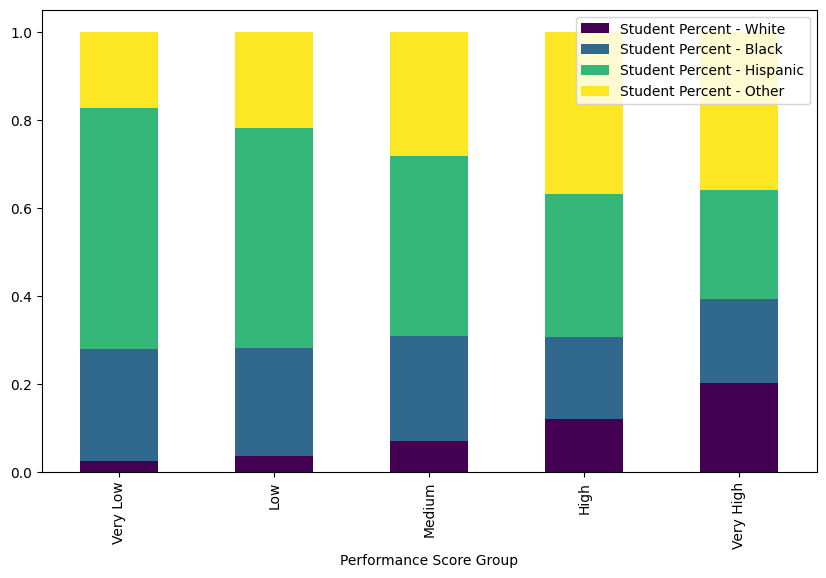

In [61]:
# Use stacked bars  to visualize the percent white, black, and hispanic students in each performance group
scoring_by_performance.set_index("Performance Score Group").plot(
    kind="bar",
    stacked=True,
    y=[
        "Student Percent - White",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Other",
    ],
    figsize=(10, 6),
    colormap="viridis",
)

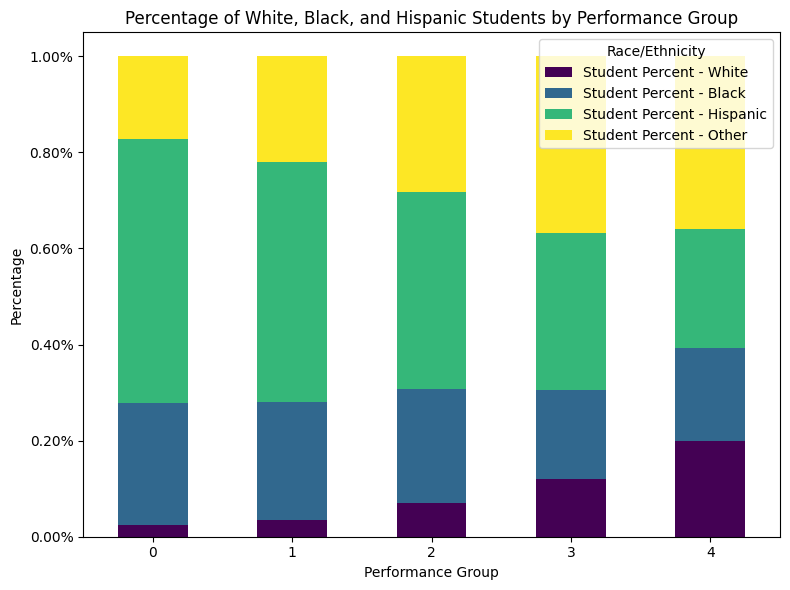

In [62]:
import matplotlib.ticker as mticker

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Stacked bar plot with percentages
scoring_by_performance.plot(
    kind="bar",
    stacked=True,
    y=[
        "Student Percent - White",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Other",
    ],
    colormap="viridis",
    ax=ax,
)

# Labels and title
ax.set_ylabel("Percentage")
ax.set_xlabel("Performance Group")
ax.set_title("Percentage of White, Black, and Hispanic Students by Performance Group")
ax.legend(title="Race/Ethnicity")

# Format y-axis as percentages
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [63]:
df_long = pd.melt(
    scoring_by_performance,
    id_vars=["Performance Score Group"],
    value_vars=[
        "Student Percent - White",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Other",
    ],
    var_name="Race/Ethnicity",
)

df_long["Race/Ethnicity"] = df_long["Race/Ethnicity"].str.replace(
    "Student Percent - ", ""
)
df_long["y_sort"] = df_long["Race/Ethnicity"].map(
    {"Other": 3, "Black": 1, "Hispanic": 2, "White": 0}
)
df_long

,Performance Score Group,Race/Ethnicity,value,y_sort
0,Very Low,White,0.025163,0
1,Low,White,0.035822,0
2,Medium,White,0.069858,0
3,High,White,0.120544,0
4,Very High,White,0.200258,0
5,Very Low,Black,0.252893,1
6,Low,Black,0.244941,1
7,Medium,Black,0.238259,1
8,High,Black,0.184520,1
9,Very High,Black,0.192941,1


In [64]:
x_sort = ["Very Low", "Low", "Medium", "High", "Very High"]
y_sort = ["Black", "Hispanic", "White", "Other"]

color_scale = alt.Scale(
    domain=y_sort,
    range=[
        "rgb(0,110,160,0.7)",
        "rgb(50,192,210, 0.8)",
        "rgb(224,178,101, 0.8)",
        "rgb(0,150,159,0.15)",
    ],  # "Other" is 50% transparent
)
chart = (
    alt.Chart(df_long)
    .mark_bar(size=40)
    .encode(
        x=alt.X(
            "Performance Score Group:N",
            title=None,
            sort=x_sort,
            axis=alt.Axis(
                labelAngle=0,
                titlePadding=1,
                titleFontSize=14,
                labelFont="Noto Sans Display",
            ),
        ),
        y=alt.Y(
            "value:Q",
            title=None,
            axis=alt.Axis(
                labelAngle=0,
            ),
        ).stack("zero"),
        # color=alt.Color("Race/Ethnicity:N", title="Race/Ethnicity"),
        color=alt.Color("Race/Ethnicity:N", title="Race/Ethnicity", scale=color_scale),
        order=alt.Order("y_sort:O", sort="ascending"),
    )
    .properties(
        title={
            "text": "Race/Ethnicity Composition by School Performance",
            "subtitle": "Public Schools Grouped by Performance Score Quintiles",
            "subtitleFontSize": 14,
        },
        width=400,
        height=400,
    )
)

In [65]:
# Display the chart
chart

alt.Chart(...)

In [66]:
# Add the text annotation
text_layer = (
    alt.Chart(df_long)
    .mark_text(
        align="center",
        baseline="top",
        dy=10,
        font="Noto Sans Display",
        fontWeight=600,
        fontSize=13,
    )
    .encode(
        x=alt.X("Performance Score Group:N", sort=x_sort),
        y=alt.Y("value:Q").stack("normalize"),
        text=alt.condition(
            alt.datum.value >= 0.1, alt.Text("value:Q", format=".0%"), alt.value("")
        ),
        order=alt.Order("y_sort:O", sort="ascending"),
        detail="Race/Ethnicity:N",
    )
)


# Add a text annotation as the data source
source_text = (
    alt.Chart(
        pd.DataFrame(
            {
                "text": [
                    "Source: 2024 School Quality Reports from New York City Public Schools Info Hub"
                ]
            }
        )
    )
    .mark_text(
        align="left",
        baseline="top",
        color="gray",
        font="Noto Sans Display",
        fontWeight=400,
        fontSize=10,
    )
    .encode(
        x=alt.value(-20),  # Align left
        y=alt.value(430),  # Position near bottom of chart
        text="text",
    )
)

rule = alt.Chart().mark_rule().encode(y=alt.Y(datum=0.2))
label = rule.mark_text(
    align="center",
    baseline="bottom",
    dx=235,
    dy=5,
    fontSize=12,
    fontWeight=200,
    font="Noto Sans Display",
).encode(text=alt.value("Segregation"))

# Combine the chart with the source text
final_chart = chart + text_layer + source_text + rule + label

# Display the chart
final_chart

alt.LayerChart(...)

---

### City-level Performance by Race/Ethnicity
ELA/Math Proficiency, mean scores by race/ethnicity

In [67]:
proficiency_by_race = (
    df_race_long.groupby(["Category"])
    .agg(
        {
            "ELA Proficient": lambda x: x.mean() / 100,
            "Math Proficient": lambda x: x.mean() / 100,
        }
    )
    .reset_index()
)

mean_scores_by_race = (
    df_race_long.groupby(["Category"])
    .agg(
        {
            "ELA Mean Scale Score": "mean",
            "Math Mean Scale Score": "mean",
        }
    )
    .reset_index()
)

In [68]:
proficiency_by_race.rename(
    columns={"ELA Proficient": "ELA", "Math Proficient": "Math"}, inplace=True
)
proficiency_by_race = pd.melt(
    proficiency_by_race,
    id_vars=["Category"],
    value_vars=["ELA", "Math"],
    var_name="Subject",
)
proficiency_by_race

,Category,Subject,value
0,Asian,ELA,0.570410
1,Black,ELA,0.300421
2,Hispanic,ELA,0.305170
3,White,ELA,0.506706
4,Asian,Math,0.651005
5,Black,Math,0.261725
6,Hispanic,Math,0.294881
7,White,Math,0.523213


In [69]:
proficiency_bar = (
    alt.Chart(proficiency_by_race)
    .mark_bar(size=34)
    .encode(
        x=alt.X("Subject:N", axis=None),
        y=alt.Y("value:Q", title=None, axis=alt.Axis(format=".0%", grid=False)),
        color=alt.Color(
            "Subject:N", title="Subject", scale=alt.Scale(domain=["ELA", "Math"])
        ),
    )
    .properties(width=90)
)

achievement_gap_text = (
    alt.Chart(proficiency_by_race)
    .mark_text()
    .encode(
        x=alt.X("Subject:N", axis=None),
        y=alt.Y("value:Q", title=None, axis=alt.Axis(format=".0%", grid=False)),
    )
)

source_text = (
    alt.Chart(
        pd.DataFrame(
            {
                "text": [
                    "Source: 2024 School Quality Reports from New York City Public Schools Info Hub"
                ]
            }
        )
    )
    .mark_text(
        align="left",
        baseline="top",
        color="gray",
        font="Noto Sans Display",
        fontWeight=400,
        fontSize=10,
    )
    .encode(
        x=alt.value(-20),  # Align left
        y=alt.value(430),  # Position near bottom of chart
        text="text",
    )
)


proficiency_gap = (
    alt.layer(proficiency_bar, achievement_gap_text)
    .facet(
        column=alt.Column(
            "Category:N", sort=["Black", "Hispanic", "White", "Asian"], title=None
        ),
    )
    .properties(
        title={
            "text": "Ethnicity-based Achievement Gap in NYC Public Schools",
            "fontSize": 16,
            "subtitleFontSize": 13,
            "subtitle": "Average Proficiency Rate of ELA and Math in New York State Exam",
        },
    )
    .configure_header(
        labelFontSize=12, labelFont="Noto Sans Display", labelOrient="bottom"
    )
    .configure_view(continuousHeight=400, continuousWidth=400, fill="#EBF2f6")
)

proficiency_gap

alt.FacetChart(...)

In [345]:
from altair import Padding


proficiency_bar = (
    alt.Chart(proficiency_by_race)
    .mark_bar(size=30)
    .encode(
        x=alt.X("value:Q", title=None, axis=alt.Axis(format=".0%", grid=False)),
        y=alt.Y("Category:N", sort=["Black", "Hispanic", "White", "Asian"]),
        color=alt.Color(
            "Subject:N", title="Subject", scale=alt.Scale(domain=["ELA", "Math"])
        ),
    )
    .properties(
        height=180,
    )
)

achievement_gap_text = (
    alt.Chart(proficiency_by_race)
    .mark_text(
        font="Noto Sans Display", fontSize=14, fontWeight=600, align="left", dx=8
    )
    .encode(
        x=alt.X("value:Q", title=None, axis=alt.Axis(format=".0%", grid=False)),
        y=alt.Y(
            "Category:N",
            sort=["Black", "Hispanic", "White", "Asian"],
            axis=alt.Axis(grid=False, labelFont="Noto Sans Display", labelFontSize=12),
            title=None,
        ),
        text=alt.Text("value:Q", format=".0%"),
        color=alt.Color(
            "Subject:N",
            title="Subject",
            scale=alt.Scale(domain=["ELA", "Math"], range=["#006EA0", "#E0B265"]),
        ),
    )
)

source_text = (
    alt.Chart(
        pd.DataFrame(
            {
                "text": [
                    """
                    Source: 2013-2019 School-level English Language Arts and Math State Tests from New York City Department of Education\n
                    Note: Students have a score that reaches achievement level 3 in the New York State exam are considered as proficient in that subject.
                    """
                ]
            }
        )
    )
    .mark_text(
        align="left",
        baseline="top",
        color="gray",
        font="Noto Sans Display",
        fontWeight=400,
        fontSize=10,
        lineBreak="\n",
        lineHeight=8
    )
    .encode(
        x=alt.value(-40),  # Align left
        y=alt.value(5),  # Position near bottom of chart
        text="text",
    )
)

proficiency_gap = alt.layer(proficiency_bar, achievement_gap_text).facet(
    column=alt.Column("Subject:N", title=None),
)


proficiency_gap_with_source = (
    alt.vconcat(proficiency_gap, source_text)
    .properties(
        title={
            "text": "Ethnicity-based Achievement Gap in NYC Public Schools",
            "fontSize": 18,
            "subtitleFontSize": 14,
            "subtitle": "Average Proficiency Rate of ELA and Math in New York State Exam",
        },
        spacing=5,
    )
    .configure_header(
        labelFontSize=12, labelFont="Noto Sans Display", labelOrient="bottom"
    )
    .configure_view(
        fill="#EBF2f6",
        continuousWidth=400,
    )
)


proficiency_gap_with_source

alt.VConcatChart(...)

---

### Performance Gap between Segregated Schools and Non-segregated Schools

In [71]:
df_public_final.groupby(["Segregated School"]).agg(
    {
        "School Name_x": "count",
        "Title I Eligible": "mean",
        "Percentage of FRL": "mean",
        "ELA Proficient": "mean",
        "Math Proficient": "mean",
        "Impact Score": "mean",
        "Performance Score": "mean",
    }
)

,School Name_x,Title I Eligible,Percentage of FRL,ELA Proficient,Math Proficient,Impact Score,Performance Score
Segregated School,,,,,,,
0.0,1848,0.334416,45.172073,58.516308,60.420854,0.550607,0.674751
1.0,5325,0.953427,81.099489,28.895785,28.539912,0.472403,0.438027


In [72]:
df_public_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 47 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   School Name_x                                7173 non-null   object 
 1   State Name                                   7173 non-null   object 
 2   County Name                                  7173 non-null   object 
 3   City                                         7173 non-null   object 
 4   ZIP                                          7173 non-null   object 
 5   School Type                                  7173 non-null   object 
 6   Charter School                               7173 non-null   int64  
 7   Magnet School                                7173 non-null   int64  
 8   Urban-centric Locale                         7173 non-null   object 
 9   Title I Eligible                             7173 non-null   int64  
 10  

In [86]:
# Plot the Black Math proficient rate in segregate schools and non-segregated schools
black_hispanic_white_math_proficient = df_public_final[["DBN", "Year", "Segregated School", "Black Math Proficient", "Hispanic Math Proficient", "White Math Proficient"]]



black_hispanic_white_math_proficient = pd.melt(black_hispanic_white_math_proficient, id_vars=["DBN", "Year", "Segregated School"], 
                                               value_vars=["Black Math Proficient", "Hispanic Math Proficient", "White Math Proficient"], 
                                               var_name= "Ethnicity")
black_hispanic_white_math_proficient.dropna(subset=["value"], inplace=True)

race_math_proficient_years = black_hispanic_white_math_proficient.groupby(["Segregated School", "Year", "Ethnicity"]).agg({"value":"mean"}).reset_index()
race_math_proficient_years.columns= ['Segregated School', "Year", "Ethnicity", "Proficient Rate"]
race_math_proficient_years["Proficient Rate"] = race_math_proficient_years["Proficient Rate"] / 100

In [95]:
# Use altair to plot the line chart of the black_hispanic_white_math_proficient

black_hispanic_math_proficient = race_math_proficient_years[
    race_math_proficient_years["Ethnicity"].isin(["Black Math Proficient", "Hispanic Math Proficient"])
]

black_hispanic_math_proficient_chart = (
    alt.Chart(black_hispanic_math_proficient)
    .mark_line()
    .encode(
        x=alt.X("Year:O", title="Year"),
        y=alt.Y(
            "Proficient Rate:Q",
            title=None,
            axis=alt.Axis(format=".0%", titleBaseline="bottom", titleAnchor="end")
        ),
        color=alt.Color("Ethnicity:N", title="Ethnicity"),
        strokeDash=alt.StrokeDash("Segregated School:N", title="Segregated School"),
    )
    .properties(
        title={
            "text": "Black and Hispanic Math Proficiency Rate in NYC Public Schools",
            "subtitle": "Schools Grouped by Segregation Status",
            "subtitleFontSize": 14,
        },
        width=500,
        height=400,
    )
)
black_hispanic_math_proficient_chart

alt.Chart(...)

In [101]:
df_race_scores = df_race_long[["DBN", "Category", "Year", "ELA Mean Scale Score", "Math Mean Scale Score"]]
df_race_scores.dropna(subset=["ELA Mean Scale Score", "Math Mean Scale Score"], inplace=True)
df_race_scores_w_public = df_race_scores.merge(df_public_final[["DBN", "Segregated School"]], on="DBN", how="left")
df_race_scores_w_public

/var/folders/pp/s_ymht6j1vl62cxbn9rkd1jh0000gn/T/ipykernel_20841/2834639682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_race_scores.dropna(subset=["ELA Mean Scale Score", "Math Mean Scale Score"], inplace=True)


,DBN,Category,Year,ELA Mean Scale Score,Math Mean Scale Score,Segregated School
0,01M015,Black,2013,284.178558,272.464294,1.0
1,01M015,Black,2013,284.178558,272.464294,1.0
2,01M015,Black,2013,284.178558,272.464294,1.0
3,01M015,Black,2013,284.178558,272.464294,1.0
4,01M015,Black,2013,284.178558,272.464294,1.0
...,...,...,...,...,...,...
135383,32K562,Hispanic,2019,592.557739,591.265381,1.0
135384,32K562,Hispanic,2019,592.557739,591.265381,1.0
135385,32K562,Hispanic,2019,592.557739,591.265381,1.0
135386,32K562,Hispanic,2019,592.557739,591.265381,1.0


In [112]:
df_prep = df_race_scores_w_public.groupby([
    "Segregated School", "Year", "Category"
    ]).agg({
        'ELA Mean Scale Score':'mean', 'Math Mean Scale Score':'mean'
        }).reset_index()

df_prep

,Segregated School,Year,Category,ELA Mean Scale Score,Math Mean Scale Score
0,0.0,2013,Asian,323.415445,332.753917
1,0.0,2013,Black,304.303479,302.061015
2,0.0,2013,Hispanic,304.422956,304.854435
3,0.0,2013,White,318.660122,320.672752
4,0.0,2014,Asian,323.297406,336.834053
5,0.0,2014,Black,305.257106,305.524171
6,0.0,2014,Hispanic,305.626930,309.549720
7,0.0,2014,White,318.992970,325.510650
8,0.0,2015,Asian,325.665782,338.325729
9,0.0,2015,Black,306.018052,306.293458


---

### NAEP Scores for Comparing NYC Race Achievement Gap with National Average
[NAEP](https://www.nationsreportcard.gov/)

In [136]:
df_naep_reading = pd.read_excel("./data/NAEP_Reading_Race_Cleaned.xlsx", header=0)
df_naep_reading.dropna(subset=["Average scale score"], inplace=True)
df_naep_reading.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 0 to 663
Data columns (total 8 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Year                                                  344 non-null    int64  
 1   Jurisdiction                                          344 non-null    object 
 2   Race/ethnicity used to report trends, schoolreported  344 non-null    object 
 3   Average scale score                                   344 non-null    float64
 4   below Basic                                           344 non-null    float64
 5   at Basic                                              344 non-null    float64
 6   at Proficient                                         344 non-null    float64
 7   at Advanced                                           264 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 24.2+ KB


In [137]:
df_naep_math = pd.read_excel("./data/NAEP_Math_Cleaned.xlsx", sheet_name="Sheet1", header=0)
df_naep_math.dropna(subset=["Average scale score"], inplace=True)
df_naep_math.rename(columns={
    "Average scale score": "Math Mean Scale Score",
    "Race/ethnicity used to report trends, school-reported": "Race/Ethnicity",
}, inplace=True)

df_naep_math.fillna(0, inplace=True)
df_naep_math['Math Proficient Rate'] = (df_naep_math["at Proficient"] + df_naep_math["at Advanced"])/100

df_naep_math_cleaned = df_naep_math[["Year", "Jurisdiction", "Race/Ethnicity", "Math Mean Scale Score", "Math Proficient Rate"]]
df_naep_math_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, 0 to 663
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   345 non-null    int64  
 1   Jurisdiction           345 non-null    object 
 2   Race/Ethnicity         345 non-null    object 
 3   Math Mean Scale Score  345 non-null    float64
 4   Math Proficient Rate   345 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 16.2+ KB


In [138]:
df_naep_reading = pd.read_excel("./data/NAEP_Reading_Race_Cleaned.xlsx", header=0)
df_naep_reading.dropna(subset=["Average scale score"], inplace=True)
df_naep_reading.rename(columns={
    "Average scale score": "Reading Mean Scale Score",
    "Race/ethnicity used to report trends, schoolreported": "Race/Ethnicity",
}, inplace=True)

df_naep_reading.fillna(0, inplace=True)
df_naep_reading['Reading Proficient Rate'] = (df_naep_reading["at Proficient"] + df_naep_reading["at Advanced"])/100
df_naep_reading.loc[df_naep_reading['Jurisdiction'] == "MiamiDade", 'Jurisdiction'] = "Miami-Dade"
df_naep_reading_cleaned = df_naep_reading[["Year", "Jurisdiction", "Race/Ethnicity", "Reading Mean Scale Score", "Reading Proficient Rate"]]

df_naep_reading_cleaned.info()

df_naep_reading_cleaned.Jurisdiction.unique()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, 0 to 663
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      344 non-null    int64  
 1   Jurisdiction              344 non-null    object 
 2   Race/Ethnicity            344 non-null    object 
 3   Reading Mean Scale Score  344 non-null    float64
 4   Reading Proficient Rate   344 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 16.1+ KB


array(['National public', 'Albuquerque', 'Atlanta', 'Austin',
       'Baltimore City', 'Boston', 'Charlotte', 'Chicago',
       'Clark County (NV)', 'Cleveland', 'Dallas', 'Denver', 'Detroit',
       'District of Columbia (DCPS)', 'Duval County (FL)',
       'Fort Worth (TX)', 'Fresno', 'Guilford County (NC)',
       'Hillsborough County (FL)', 'Houston', 'Jefferson County (KY)',
       'Los Angeles', 'Miami-Dade', 'Milwaukee', 'New York City',
       'Philadelphia', 'San Diego', 'Shelby County (TN)'], dtype=object)

In [141]:
df_naep_cleaned = pd.merge(df_naep_reading_cleaned, df_naep_math_cleaned, on=["Year", "Jurisdiction", "Race/Ethnicity"], how="outer")

df_naep_cleaned.dropna(subset=["Math Mean Scale Score", "Reading Mean Scale Score"], inplace=True)

In [175]:
df_naep_long = pd.melt(df_naep_cleaned, id_vars=["Year", "Jurisdiction", "Race/Ethnicity"], value_vars=["Math Proficient Rate", "Reading Proficient Rate"], var_name="Subject", value_name="Proficient Rate")
df_naep_long.dropna(subset=["Proficient Rate"], inplace=True)
df_naep_long

,Year,Jurisdiction,Race/Ethnicity,Subject,Proficient Rate
0,2013,Albuquerque,Hispanic,Math Proficient Rate,0.183925
1,2013,Albuquerque,White,Math Proficient Rate,0.486404
2,2013,Atlanta,Black,Math Proficient Rate,0.107081
3,2013,Atlanta,Hispanic,Math Proficient Rate,0.072502
4,2013,Atlanta,White,Math Proficient Rate,0.679291
...,...,...,...,...,...
671,2019,San Diego,Hispanic,Reading Proficient Rate,0.227123
672,2019,San Diego,Two or more races,Reading Proficient Rate,0.506019
673,2019,San Diego,White,Reading Proficient Rate,0.527005
674,2019,Shelby County (TN),Black,Reading Proficient Rate,0.127724


In [142]:
df_naep_cleaned.Jurisdiction.unique()

array(['Albuquerque', 'Atlanta', 'Austin', 'Baltimore City', 'Boston',
       'Charlotte', 'Chicago', 'Cleveland', 'Dallas', 'Detroit',
       'District of Columbia (DCPS)', 'Fresno',
       'Hillsborough County (FL)', 'Houston', 'Jefferson County (KY)',
       'Los Angeles', 'Miami-Dade', 'Milwaukee', 'National public',
       'New York City', 'Philadelphia', 'San Diego', 'Duval County (FL)',
       'Clark County (NV)', 'Denver', 'Fort Worth (TX)',
       'Guilford County (NC)', 'Shelby County (TN)'], dtype=object)

In [150]:
# Calculate the differences between White and Black, White and Hispanic Students in Reading proficiency rate and Math proficiency rate
df_naep_pivot = pd.pivot_table(df_naep_cleaned[df_naep_cleaned['Race/Ethnicity'].isin(["White", "Hispanic", "Black"])], index=["Year", "Jurisdiction"], columns=["Race/Ethnicity"], values=["Reading Proficient Rate", "Math Proficient Rate"])
df_naep_pivot.columns = df_naep_pivot.columns.to_flat_index()
df_naep_pivot.columns = [' '.join(col).strip() for col in df_naep_pivot.columns.values]
df_naep_pivot = df_naep_pivot.reset_index()

df_naep_pivot.sort_values(by=["Jurisdiction", "Year"], inplace=True)
df_naep_pivot.dropna(inplace=True)

In [151]:
df_naep_pivot

,Year,Jurisdiction,Math Proficient Rate Black,Math Proficient Rate Hispanic,Math Proficient Rate White,Reading Proficient Rate Black,Reading Proficient Rate Hispanic,Reading Proficient Rate White
1,2013,Atlanta,0.107081,0.072502,0.679291,0.151865,0.199125,0.707490
23,2015,Atlanta,0.109252,0.183710,0.794534,0.132679,0.230734,0.660463
45,2017,Atlanta,0.098112,0.195174,0.716502,0.132229,0.267028,0.754786
73,2019,Atlanta,0.102172,0.237484,0.643953,0.154938,0.188469,0.668868
2,2013,Austin,0.165304,0.206305,0.700032,0.142158,0.187774,0.607815
...,...,...,...,...,...,...,...,...
21,2013,San Diego,0.136624,0.154210,0.534210,0.133194,0.149344,0.519852
43,2015,San Diego,0.089075,0.170045,0.524309,0.177257,0.177128,0.546967
70,2017,San Diego,0.162017,0.176221,0.576905,0.136147,0.205076,0.544199
98,2019,San Diego,0.165133,0.139315,0.606705,0.158524,0.227123,0.527005


In [162]:
jurisdiction_sort = ["New York City", "National public"] + [i for i in df_naep_pivot.Jurisdiction.unique() if i not in ["New York City", "National public"]]
jurisdiction_sort

['New York City',
 'National public',
 'Atlanta',
 'Austin',
 'Baltimore City',
 'Boston',
 'Charlotte',
 'Chicago',
 'Clark County (NV)',
 'Cleveland',
 'Denver',
 'District of Columbia (DCPS)',
 'Duval County (FL)',
 'Fort Worth (TX)',
 'Fresno',
 'Guilford County (NC)',
 'Hillsborough County (FL)',
 'Houston',
 'Jefferson County (KY)',
 'Los Angeles',
 'Miami-Dade',
 'Milwaukee',
 'Philadelphia',
 'San Diego',
 'Shelby County (TN)']

In [265]:
opacity = alt.condition(
    alt.FieldOneOfPredicate(field="Jurisdiction", oneOf=["New York City", "National public"]),
    alt.value(1),
    alt.value(0.15),
)

opacity_text = alt.condition(
    (alt.FieldOneOfPredicate(field="Jurisdiction", oneOf=["New York City", "National public"])) & (alt.datum.Year==2019),
    alt.value(1),
    alt.value(0),
)

black_proficiency_chart = alt.Chart(df_naep_pivot).mark_line().encode(
    x=alt.X("Year:O"), # Convert Year to ordinal for categorical spacing
    y=alt.Y("Math Proficient Rate Black:Q", title=None),
    color=alt.Color("Jurisdiction:N", sort=jurisdiction_sort, legend=alt.Legend(labelFontSize=8, titleFontSize=10)),
    opacity=opacity,
).properties(
    title="Math Proficiency Trends for Black Students by Jurisdictions",
    width=400,
    height=400
)

black_ela_proficiency_chart = alt.Chart(df_naep_pivot).mark_line().encode(
    x=alt.X("Year:O"), # Convert Year to ordinal for categorical spacing
    y=alt.Y("Reading Proficient Rate Black:Q", title=None),
    color=alt.Color("Jurisdiction:N", sort=jurisdiction_sort, labelFontSize=10, titleFontSize=10),
    opacity=opacity,
).properties(
    title="Reading Proficiency Trends for Black Students by Jurisdiction",
    width=400,
    height=400
)


black_proficiency_chart

alt.Chart(...)

In [344]:
df_naep_long_black = df_naep_long[df_naep_long['Race/Ethnicity'].isin(['Black'])]
df_naep_long_hispanic = df_naep_long[df_naep_long['Race/Ethnicity']=='Hispanic']


base_black_chart = alt.Chart(df_naep_long_black).mark_line().encode(
    x=alt.X("Year:O", axis=alt.Axis(labelAngle=0, title=None, labelAlign='center'), scale=alt.Scale(padding=0, paddingOuter=0.1)),
    y=alt.Y("Proficient Rate:Q", axis=alt.Axis(format=".0%", title="Black Students", titleAlign="left", titleAngle=90, titleAnchor="end", titlePadding=0, titleY=-10)),
    color=alt.Color("Jurisdiction:N", sort=jurisdiction_sort, legend=alt.Legend(labelFontSize=10, titleFontSize=12)),
    opacity=opacity,
).properties(
    width=350,
    height=300,
)

base_hispanic_chart = alt.Chart(df_naep_long_hispanic).mark_line().encode(
    x=alt.X("Year:O", axis=alt.Axis(labelAngle=0, title=None, labelAlign='center'), scale=alt.Scale(padding=0, paddingOuter=0.1)),
    y=alt.Y("Proficient Rate:Q", axis=alt.Axis(format=".0%", title="Hispanic Students", titleAlign="left", titleAngle=90, titleAnchor="end", titlePadding=0, titleY=-20)),
    color=alt.Color("Jurisdiction:N", sort=jurisdiction_sort, legend=alt.Legend(labelFontSize=10, titleFontSize=12)),
    opacity=opacity,
).properties(
    width=350,
    height=300,
)


label_layer_black = alt.Chart(df_naep_long_black).mark_text(fontSize=12, font="Noto Sans Display", baseline='middle', align='left', limit=100).encode(
        x=alt.X("Year:O"),
        y=alt.Y("Proficient Rate:Q", axis=alt.Axis(format=".0%")),
        text=alt.Text("Jurisdiction:N"),
        opacity=opacity_text,
    )

label_layer_hispanic = alt.Chart(df_naep_long_hispanic).mark_text(fontSize=12, font="Noto Sans Display", baseline='middle', align='left', limit=100).encode(
        x=alt.X("Year:O"),
        y=alt.Y("Proficient Rate:Q", axis=alt.Axis(format=".0%")),
        text=alt.Text("Jurisdiction:N"),
        opacity=opacity_text,
    )

source_text = (
    alt.Chart(
        pd.DataFrame(
            {
                "text": [
                    """
                    Source: 2013-2019 National Assessment of Education Progress (NAEP) from National Center for Education Statistics \n
                    Notes: Students reached achievement level as "at Proficient" or higher in the NAEP exams are considered as proficient in that subject.
                    """
                ]
            }
        )
    )
    .mark_text(
        align="left",
        baseline="top",
        color="gray",
        font="Noto Sans Display",
        fontWeight=400,
        fontSize=10,
        lineBreak="\n",
        lineHeight=8
    )
    .encode(
        x=alt.value(-40),  # Align left
        y=alt.value(5),  # Position near bottom of chart
        text="text",
    )
)


# Facet by Race
facet_chart_black = alt.layer(base_black_chart, label_layer_black).facet(
    column=alt.Column("Subject:N", title=None),
)

facet_chart_hispanic = alt.layer(base_hispanic_chart, label_layer_hispanic).facet(
    column=alt.Column("Subject:N", title=None),
)

final_race_gap_chart = alt.vconcat(facet_chart_black, facet_chart_hispanic, source_text).properties(
        title={
            "text": "Proficiency Trends for Black and Hispanic Students in Major Urban Jurisdictions",
            "subtitle": "Black and Hispanic students in NYC are slightly underperformed in Grade 8 compared to national average",
            "offset": 30
            },
        spacing=40,
).configure_header(
    labelFontSize=12, labelFont="Noto Sans Display", labelFontWeight=600
).configure_view(
    fill="#EBF2f6",
    continuousWidth=400,
    continuousHeight=400,
)

final_race_gap_chart

alt.VConcatChart(...)